# Task 2: Data Cleaning and Preprocessing

### Description: Clean and preprocess a raw dataset to make it suitable for analysis.

- Handle missing data (e.g., imputation, removal).
- Detect and remove outliers.
- Convert categorical variables into numerical format using one-hot encoding or label encoding.
- Normalize or standardize numerical data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import re

# Data Cleaning

In [2]:
df = pd.read_csv("data/ethopian_airways_reviews.csv")
df.head()

,title,verified,content
0,40 reviewsJ Lim(Hong Kong)10th December 2025,✅\nTrip Verified,The airline that claims to be the pride of Afr...
1,E Honscher(United States)9th December 2025,✅\nTrip Verified,Poor ground service lacking integrity with reb...
2,M Kiprono(Kenya)28th November 2025,✅\nTrip Verified,I travelled to London from Nairobi. On my way ...
3,D Mayal(Zambia)20th October 2025,✅\nTrip Verified,They served the food during the long hours fli...
4,8 reviewsAlok Mishra(Nepal)7th October 2025,✅\nTrip Verified,"The plane was not so clean, crew member were n..."


### Separating name

In [3]:
# cutting out name from title
df[["name", 'title']] = df['title'].str.split('(', n=1, expand=True)

In [4]:
# removing number of review pattern in name
review_pattern = r"\d{1,3}\sreviews"
for index, names in df["name"].items():
    match = re.findall(review_pattern, names)
    df.loc[index, "name"] = re.sub(review_pattern, "", names)

In [5]:
# removing date from name column
df["name"] = df["name"].str.replace("2", ",2")

In [6]:
df[["name", 'date2']] = df['name'].str.split(',', n=1, expand=True)

In [7]:
df["date2"] = df["date2"].str.replace(" ,", ", ")

### Country Column

In [8]:
# cuttimg out country from title
df[["country", 'title']] = df['title'].str.split(')', n=1, expand=True)

In [9]:
# Cleaning the 'verified' column by removing specific leading characters
irregular_pattern = "Cotonou to Nairobi via Addis Ababa. The Ethiopian Airlines experience is horrible from one end to the other. ✅\n"
df["verified"] = df["verified"].str.lstrip("✅\n|c\n|❎\n|❌\n")
df["verified"] = df["verified"].str.lstrip(irregular_pattern)
df["verified"] = df["verified"].str.rstrip(' Review')

### Aircraft

In [10]:
df[["content", 'Aircraft']] = df['content'].str.split('\nAircraft\n|\nType Of Traveller|\nSeat Type', n=1, expand=True)

In [11]:
df[["Aircraft", 'traveller_type']] = df['Aircraft'].str.split('\nType Of Traveller|\n', n=1, expand=True)

### Route

In [12]:
df[["traveller_type", 'seat_type']] = df['traveller_type'].str.split('\nDate|\nValue', n=1, expand=True)

In [13]:
df = df.drop(["seat_type"], axis = 1)

In [14]:
df[['traveller_type', "Route"]] = df['traveller_type'].str.split('\nRoute', n=1, expand=True)

In [15]:
df["Route"] = df["Route"].str.lstrip("\n")

### Seat type

In [16]:
df[["traveller_type", 'seat_type']] = df['traveller_type'].str.split('\nSeat Type', n=1, expand=True)

In [17]:
df["seat_type"] = df["seat_type"].str.lstrip("\n")
df["traveller_type"] = df["traveller_type"].str.lstrip("\n")

### Traveller type

In [18]:
df[["traveller_type", 'rough']] = df['traveller_type'].str.split('\nSeat Comfort', n=1, expand=True)

In [19]:
# Define the condition
mask = df['traveller_type'].isin(['Economy Class', 'Business Class'])

# Update seat_type by concatenating it with traveller_type for those rows
df.loc[mask, 'seat_type'] = df.loc[mask, 'traveller_type']
df.loc[mask, 'traveller_type'] = np.nan

### Drop the rough column and renaming

In [20]:
df.rename(columns={"title":"date", 'content':'comment'}, inplace=True)

In [21]:
df["date"] = df["date"].combine_first(df["date2"])

In [22]:
df = df.drop(["rough", 'date2'], axis = 1)

In [23]:
df.to_csv("data/clean_ethiopian_airlines_data.csv")

# Preprocessing

### Handle missing data (e.g., imputation, removal).

In [24]:
import missingno as msno
import matplotlib.pyplot as plt

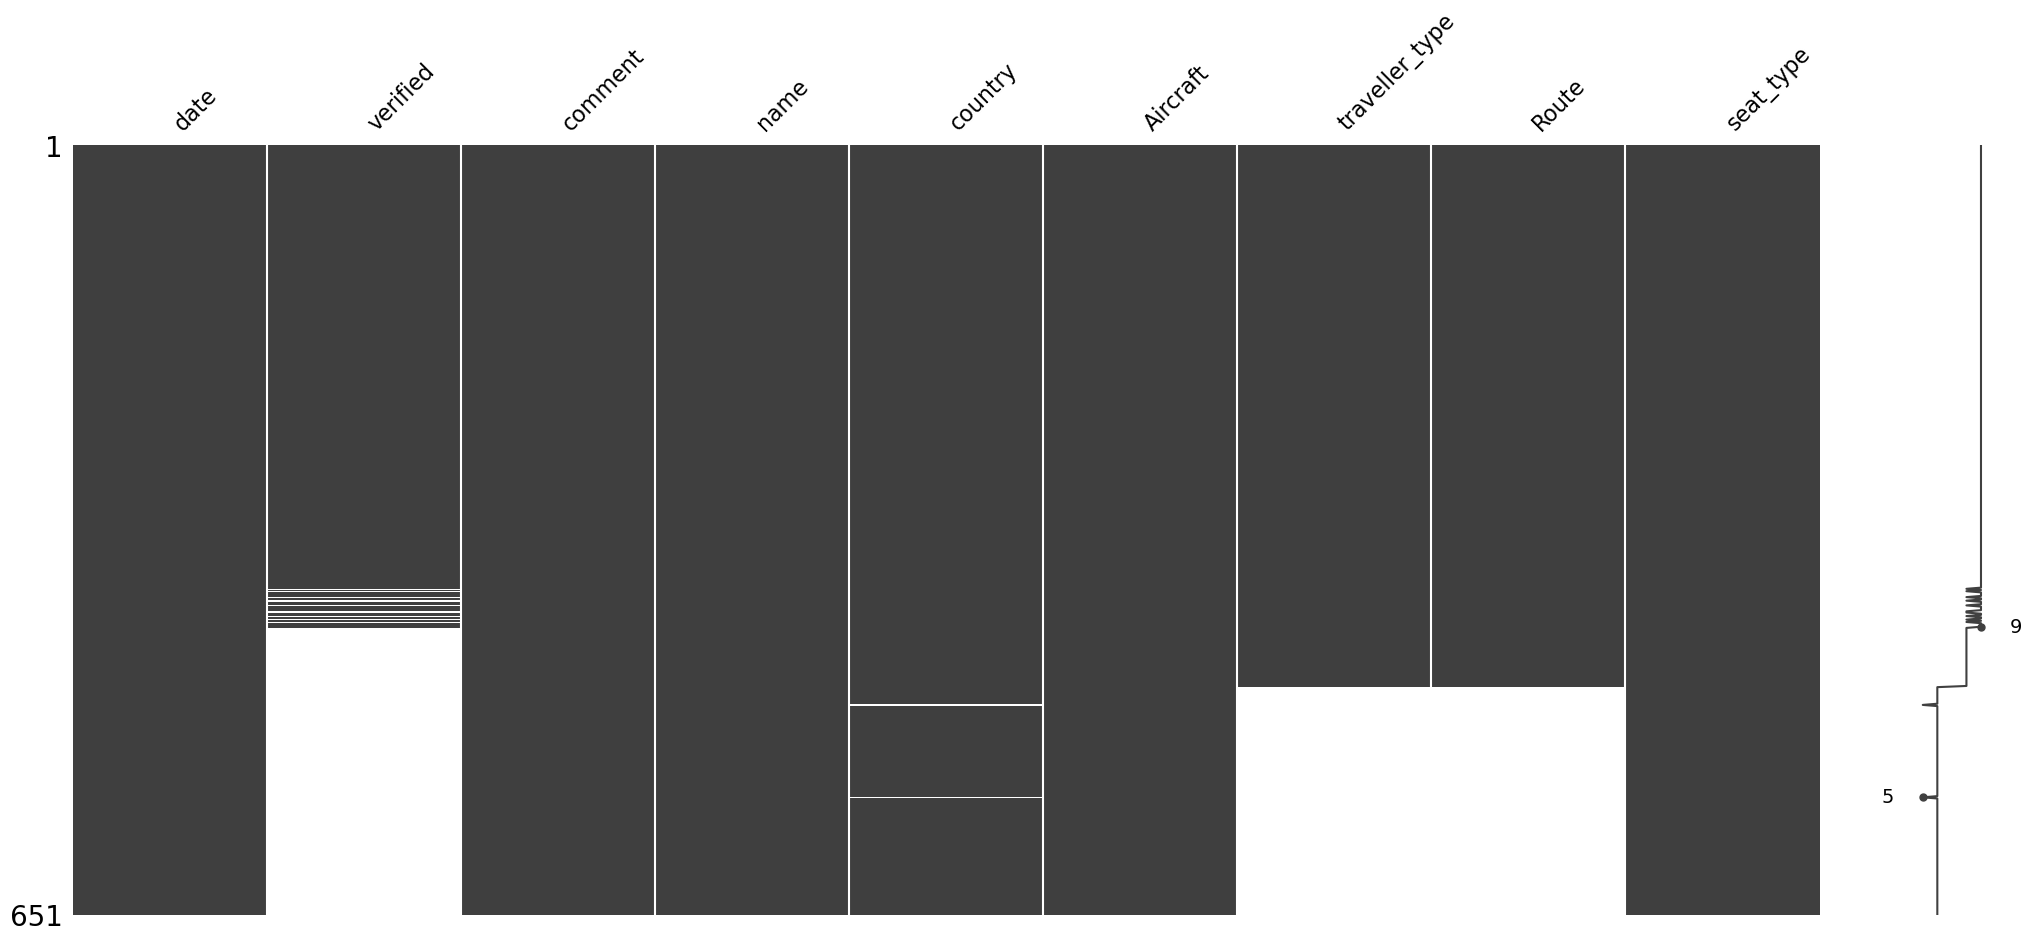

In [25]:
msno.matrix(df)
plt.show()

In [26]:
df["verified"] = df["verified"].fillna("Verified")

In [27]:
df["country"] = df["country"].ffill()

In [28]:
from sklearn.impute import SimpleImputer

In [29]:
imputer = SimpleImputer(strategy="most_frequent")
df[["traveller_type"]] = imputer.fit_transform(df[["traveller_type"]])

### To numerical

In [30]:
df["comment_length"] = df["comment"].apply(len)

In [31]:
def token_length(text):
    text_list = text.split()
    return len(text_list)

In [32]:
df["token_length"] = df["comment"].apply(token_length)

In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [34]:
encoder = OneHotEncoder(sparse_output=False)

In [35]:
# Fit and transform the 'seat_type' column
encoded_seat_type = encoder.fit_transform(df[["seat_type"]])
# Get feature names for clarity
feature_names = encoder.get_feature_names_out(['seat_type'])

In [36]:
# Create a DataFrame from the encoded features
encoded_seat_type_df = pd.DataFrame(encoded_seat_type, columns=feature_names)

In [37]:
# Initialize the scaler
scaler = StandardScaler()

In [38]:
# Fit and transform the 'Weight' column
scaled_length = scaler.fit_transform(df[['comment_length']])

In [39]:
# Create a DataFrame from the scaled features
scaled_length_df = pd.DataFrame(scaled_length, columns=['scaled_comment_length'])

In [40]:
processed_df = pd.concat([df[['seat_type']], df[['comment_length']], df[['token_length']], encoded_seat_type_df, scaled_length_df], axis=1)

In [41]:
processed_df.head(3)

,seat_type,comment_length,token_length,seat_type_Business Class,seat_type_Economy Class,seat_type_First Class,seat_type_Premium Economy,scaled_comment_length
0,Economy Class,610,111,0.0,1.0,0.0,0.0,-0.439702
1,Economy Class,658,114,0.0,1.0,0.0,0.0,-0.359101
2,Economy Class,393,66,0.0,1.0,0.0,0.0,-0.804085


In [42]:
processed_df.to_csv("data/processed_ethiopian_airlines_data.csv")